<a href="https://colab.research.google.com/github/Joboreh97/Codes-that-function/blob/main/Autoencoder_no_encoder_no_decoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End-to-end Learning with Autoencoders

In this notebook, you will learn how to implement an end-to-end communication system as an autoencoder [1].
The implemented system is shown in the figure below.
An additive white Gaussian noise (AWGN) channel is considered.
On the transmitter side, joint training of the constellation geometry and bit-labeling is performed, as in [2].
On the receiver side, a neural network-based demapper that computes log-likelihood ratios (LLRs) on the transmitted bits from the received samples is optimized.
The considered autoencoder is benchmarked against a quadrature amplitude modulation (QAM) with Gray labeling and the optimal AWGN demapper.

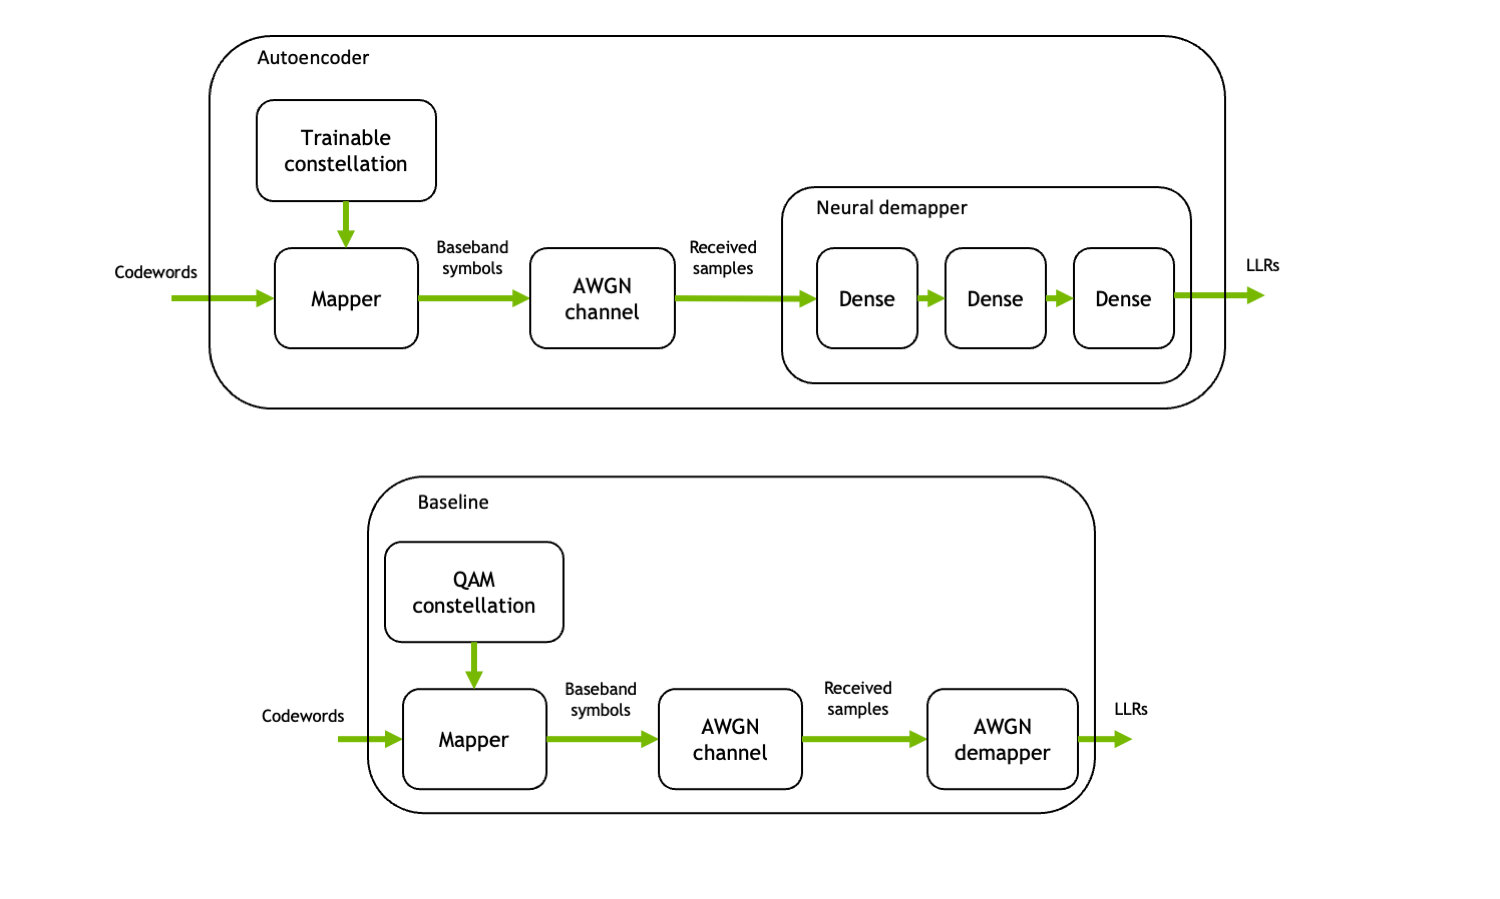


Two algorithms for training the autoencoder are implemented in this notebook:

* Conventional stochastic gradient descent (SGD) with backpropagation, which assumes a differentiable channel model and therefore optimizes the end-to-end system by backpropagating the gradients through the channel (see, e.g., [1]).
* The training algorithm from [3], which does not assume a differentiable channel model, and which trains the end-to-end system by alternating between conventional training of the receiver and reinforcement learning (RL)-based training of the transmitter. Compared to [3], an additional step of fine-tuning of the receiver is performed after alternating training.

**Note:** For an introduction to the implementation of differentiable communication systems and their optimization through SGD and backpropagation with Sionna, please refer to [the Part 2 of the Sionna tutorial for Beginners](https://nvlabs.github.io/sionna/phy/tutorials/Sionna_tutorial_part2.html).

* [GPU Configuration and Imports](#GPU-Configuration-and-Imports)
* [Simulation Parameters](#Simulation-Parameters)
* [Neural Demapper](#Neural-Demapper)
* [Trainable End-to-end System: Conventional Training](#Trainable-End-to-end-System:-Conventional-Training)
* [Trainable End-to-end System: RL-based Training](#Trainable-End-to-end-System:-RL-based-Training)
* [Evaluation](#Evaluation)
* [Visualizing the Learned Constellations](#Visualizing-the-Learned-Constellations)
* [References](#References)

## GPU Configuration and Imports

In [29]:
import os
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna.phy
except ImportError as e:
    import sys
    if 'google.colab' in sys.modules:
       # Install Sionna in Google Colab
       print("Installing Sionna and restarting the runtime. Please run the cell again.")
       os.system("pip install sionna")
       os.kill(os.getpid(), 5)
    else:
       raise e

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Dense

from sionna.phy import Block
from sionna.phy.channel import AWGN
from sionna.phy.utils import ebnodb2no, log10, expand_to_rank
from sionna.phy.fec.ldpc import LDPC5GEncoder, LDPC5GDecoder
from sionna.phy.mapping import Mapper, Demapper, Constellation, BinarySource
from sionna.phy.utils import sim_ber

sionna.phy.config.seed = 42 # Set seed for reproducible random number generation

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle

## Simulation Parameters

In [30]:
###############################################
# SNR range for evaluation and training [dB]
###############################################
ebno_db_min = 4.0
ebno_db_max = 8.0

###############################################
# Modulation and coding configuration
###############################################
num_bits_per_symbol = 6 # Baseline is 64-QAM
modulation_order = 2**num_bits_per_symbol
coderate = 0.5 # Coderate for the outer code
n = 1500 # Codeword length [bit]. Must be a multiple of num_bits_per_symbol
k = int(n*coderate) # Number of information bits per codeword
num_symbols_per_codeword = k//num_bits_per_symbol # Number of modulated baseband symbols per codeword


###############################################
# Training configuration
###############################################
num_training_iterations_conventional = 10000 # Number of training iterations for conventional training
# Number of training iterations with RL-based training for the alternating training phase and fine-tuning of the receiver phase
num_training_iterations_rl_alt = 7000
num_training_iterations_rl_finetuning = 3000
training_batch_size = tf.constant(128, tf.int32) # Training batch size
rl_perturbation_var = 0.01 # Variance of the perturbation used for RL-based training of the transmitter
model_weights_path_conventional_training = "awgn_autoencoder_weights_conventional_training" # Filename to save the autoencoder weights once conventional training is done
model_weights_path_128_unit_Demapper_model = "awgn_autoencoder_weights_128_unit_Demapper_model" # Filename to save the autoencoder weights once 128-unit Demapper model is trained
model_weights_path_64_unit_Demapper_model = "awgn_autoencoder_weights_64_unit_Demapper_model" # Filename to save the autoencoder weights once 64-unit Demapper model is trained
model_weights_path_rl_training = "awgn_autoencoder_weights_rl_training" # Filename to save the autoencoder weights once RL-based training is done

###############################################
# Evaluation configuration
###############################################
results_filename = "awgn_autoencoder_results" # Location to save the results

## Neural Demapper

The neural network-based demapper shown in the figure above is made of three dense layers with ReLU activation.

The input of the demapper consists of a received sample $y \in \mathbb{C}$ and the noise power spectral density $N_0$ in log-10 scale to handle different orders of magnitude for the SNR.

As the neural network can only process real-valued inputs, these values are fed as a 3-dimensional vector

$$\left[ \mathcal{R}(y), \mathcal{I}(y), \log_{10}(N_0) \right]$$

where $\mathcal{R}(y)$ and $\mathcal{I}(y)$ refer to the real and imaginary component of $y$, respectively.

The output of the neural network-based demapper consists of LLRs on the `num_bits_per_symbol` bits mapped to a constellation point. Therefore, the last layer consists of ``num_bits_per_symbol`` units.

**Note**: The neural network-based demapper processes the received samples $y$ forming a block individually. The [neural receiver notebook](https://nvlabs.github.io/sionna/phy/tutorials/Neural_Receiver.html) provides an example of a more advanced neural network-based receiver that jointly processes a resource grid of received symbols.

In [31]:
class NeuralDemapper(Layer):
    def __init__(self, units=128):  # default is 128
        super().__init__()
        self._dense_1 = Dense(units, activation='relu')
        self._dense_2 = Dense(units, activation='relu')
        self._dense_3 = Dense(num_bits_per_symbol, activation=None)

    def call(self, y, no):
        no_db = log10(no)
        no_db = tf.tile(no_db, [1, num_symbols_per_codeword])
        z = tf.stack([tf.math.real(y), tf.math.imag(y), no_db], axis=2)
        llr = self._dense_1(z)
        llr = self._dense_2(llr)
        llr = self._dense_3(llr)
        return llr


## Trainable End-to-end System: Conventional Training

The following cell defines an end-to-end communication system that transmits bits modulated using a trainable constellation over an AWGN channel.

The receiver uses the previously defined neural network-based demapper to compute LLRs on the transmitted (coded) bits.

As in [1], the constellation and neural network-based demapper are jointly trained through SGD and backpropagation using the binary cross entropy (BCE) as loss function.

Training on the BCE is known to be equivalent to maximizing an achievable information rate [2].

The following model can be instantiated either for training (`training = True`) or evaluation (`training = False`).

In the former case, the BCE is returned and no outer code is used to reduce computational complexity and as it does not impact the training of the constellation or demapper.

When setting `training` to `False`, an LDPC outer code from 5G NR is applied.

In [32]:
class E2ESystemConventionalTraining(Model):

    def __init__(self, training, demapper=None):
        super().__init__()
        self._training = training

        ################
        ## Transmitter
        ################
        self._binary_source = BinarySource()
        # if not self._training:
        #     self._encoder = LDPC5GEncoder(k, n, num_bits_per_symbol)

        qam_points = Constellation("qam", num_bits_per_symbol).points
        self.constellation = Constellation("custom",
                                           num_bits_per_symbol,
                                           points=qam_points,
                                           normalize=True,
                                           center=True)
        self.points_r = self.add_weight(shape=qam_points.shape, initializer="zeros")
        self.points_i = self.add_weight(shape=qam_points.shape, initializer="zeros")
        self.points_r.assign(tf.math.real(qam_points))
        self.points_i.assign(tf.math.imag(qam_points))

        self._mapper = Mapper(constellation=self.constellation)

        ################
        ## Channel
        ################
        self._channel = AWGN()

        ################
        ## Receiver
        ################
        # Plug in custom demapper or default to 128-unit version
        self._demapper = demapper if demapper is not None else NeuralDemapper(units=128)

        # if not self._training:
        #     self._decoder = LDPC5GDecoder(self._encoder, hard_out=True)

        #################
        # Loss function
        #################
        if self._training:
            self._bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    def call(self, batch_size, ebno_db):
        points = tf.complex(self.points_r, self.points_i)
        self.constellation.points = points

        if len(ebno_db.shape) == 0:
            ebno_db = tf.fill([batch_size], ebno_db)
        no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate)
        no = expand_to_rank(no, 2)

        b = self._binary_source([batch_size, k])  # Use as both input and ground truth
        c = b  # No encoding step

        x = self._mapper(c)
        y = self._channel(x, no)

        llr = self._demapper(y, no)
        llr = tf.reshape(llr, [batch_size, k])  # reshape to k bits
        if self._training:
            loss = self._bce(c, llr)
            return loss
        else:
            # For uncoded, just threshold the llr for hard decisions
            b_hat = tf.cast(llr > 0, tf.float32)
            return b, b_hat



A simple training loop is defined in the next cell, which performs `num_training_iterations_conventional` training iterations of SGD. Training is done over a range of SNR, by randomly sampling a batch of SNR values at each iteration.

**Note:** For an introduction to the implementation of differentiable communication systems and their optimization through SGD and backpropagation with Sionna, please refer to [the Part 2 of the Sionna tutorial for Beginners](https://nvlabs.github.io/sionna/phy/tutorials/Sionna_tutorial_part2.html).

In [33]:
def conventional_training(model):
    # Optimizer used to apply gradients
    optimizer = tf.keras.optimizers.Adam()

    @tf.function(jit_compile=True)
    def train_step():
        # Sampling a batch of SNRs
        ebno_db = tf.random.uniform(shape=[training_batch_size], minval=ebno_db_min, maxval=ebno_db_max)
        # Forward pass
        with tf.GradientTape() as tape:
            loss = model(training_batch_size,  ebno_db)
        # Computing and applying gradients
        weights = model.trainable_variables
        grads = tape.gradient(loss, weights)
        optimizer.apply_gradients(zip(grads, weights))
        return loss

    for i in range(num_training_iterations_conventional):
        loss = train_step()
        # Printing periodically the progress
        if i % 100 == 0:
            print('Iteration {}/{}  BCE: {:.4f}'.format(i, num_training_iterations_conventional, loss.numpy()), end='\r')

The next cell defines a utility function for saving the weights using [pickle](https://docs.python.org/3/library/pickle.html).

In [34]:
def save_weights(model, model_weights_path):
    weights = model.get_weights()
    with open(model_weights_path, 'wb') as f:
        pickle.dump(weights, f)

In the next cell, an instance of the model defined previously is instantiated and trained.

In [35]:
# Utility function to load and set weights of a model
def load_weights(model, model_weights_path):
    model(tf.cast(1, tf.int32), tf.constant(10.0, tf.float32))
    with open(model_weights_path, 'rb') as f:
        weights = pickle.load(f)
    model.set_weights(weights)
    points = tf.complex(model.points_r, model.points_i)
    model.constellation.points = points

In [36]:
# 128-unit demapper
demapper_128 = NeuralDemapper(units=128)
model_128 = E2ESystemConventionalTraining(training=True, demapper=demapper_128)
conventional_training(model_128)
save_weights(model_128, model_weights_path_128_unit_Demapper_model)

# 64-unit demapper
demapper_64 = NeuralDemapper(units=64)
model_64 = E2ESystemConventionalTraining(training=True, demapper=demapper_64)
conventional_training(model_64)
save_weights(model_64, model_weights_path_64_unit_Demapper_model)


## Trainable End-to-end System: RL-based Training

The following cell defines the same end-to-end system as before, but stop the gradients after the channel to simulate a non-differentiable channel.

To jointly train the transmitter and receiver over a non-differentiable channel, we follow [3], which key idea is to alternate between:

- Training of the receiver on the BCE using conventional backpropagation and SGD.
- Training of the transmitter by applying (known) perturbations to the transmitter output to enable estimation of the gradient of the transmitter weights with respect to an approximation of the loss function.

When `training` is set to `True`, both losses for training the receiver and the transmitter are returned.

The next cell implements the training algorithm from [3], which alternates between conventional training of the neural network-based receiver, and RL-based training of the transmitter.

In the next cell, an instance of the model defined previously is instantiated and trained.

## Evaluation

The following cell implements a baseline which uses QAM with Gray labeling and conventional demapping for AWGN channel.

In [37]:
class Baseline(Model):

    def __init__(self):
        super().__init__()

        ################
        ## Transmitter
        ################
        self._binary_source = BinarySource()
        self._encoder = LDPC5GEncoder(k, n, num_bits_per_symbol)
        constellation = Constellation("qam", num_bits_per_symbol, trainable=False)
        self.constellation = constellation
        self._mapper = Mapper(constellation=constellation)

        ################
        ## Channel
        ################
        self._channel = AWGN()

        ################
        ## Receiver
        ################
        self._demapper = Demapper("app", constellation=constellation)
        self._decoder = LDPC5GDecoder(self._encoder, hard_out=True)

    def call(self, batch_size, ebno_db):

        # If `ebno_db` is a scalar, a tensor with shape [batch size] is created as it is what is expected by some layers
        if len(ebno_db.shape) == 0:
            ebno_db = tf.fill([batch_size], ebno_db)
        no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate)
        no = expand_to_rank(no, 2)

        ################
        ## Transmitter
        ################
        b = self._binary_source([batch_size, k])
        c = self._encoder(b)
        # Modulation
        x = self._mapper(c) # x [batch size, num_symbols_per_codeword]

        ################
        ## Channel
        ################
        y = self._channel(x, no) # [batch size, num_symbols_per_codeword]

        ################
        ## Receiver
        ################
        llr = self._demapper(y, no)
        # Outer decoding
        b_hat = self._decoder(llr)
        return b,b_hat # Ground truth and reconstructed information bits returned for BER/BLER computation

In [38]:
# Range of SNRs over which the systems are evaluated
ebno_dbs = np.arange(ebno_db_min, # Min SNR for evaluation
                     ebno_db_max, # Max SNR for evaluation
                     0.5) # Step

In [39]:
# Utility function to load and set weights of a model
def load_weights(model, model_weights_path):
    model(tf.cast(1, tf.int32), tf.constant(10.0, tf.float32))
    with open(model_weights_path, 'rb') as f:
        weights = pickle.load(f)
    model.set_weights(weights)
    points = tf.complex(model.points_r, model.points_i)
    model.constellation.points = points

The next cell evaluate the baseline and the two autoencoder-based communication systems, trained with different method.
The results are stored in the dictionary ``BLER``.

In [40]:
# Dictionary storing the results
BER = {}

model_baseline = Baseline()
ber,_ = sim_ber(model_baseline, ebno_dbs, batch_size=128, num_target_block_errors=1000, max_mc_iter=1000, graph_mode="xla")
BER['baseline'] = ber.numpy()

model_eval_128 = E2ESystemConventionalTraining(training=False, demapper=demapper_128)
load_weights(model_eval_128, model_weights_path_128_unit_Demapper_model)
ber,_ = sim_ber(model_eval_128, ebno_dbs, batch_size=128, num_target_block_errors=1000, max_mc_iter=1000, graph_mode="xla")
BER['autoencoder-128units'] = ber.numpy()

model_eval_64 = E2ESystemConventionalTraining(training=False, demapper=demapper_64)
load_weights(model_eval_64, model_weights_path_64_unit_Demapper_model)
ber,_ = sim_ber(model_eval_64, ebno_dbs, batch_size=128, num_target_block_errors=1000, max_mc_iter=1000, graph_mode="xla")
BER['autoencoder-64units'] = ber.numpy()




with open(results_filename, 'wb') as f:
    pickle.dump((ebno_dbs, BER), f)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      4.0 | 1.2214e-01 | 1.0000e+00 |       93807 |      768000 |         1024 |        1024 |        10.6 |reached target block errors
      4.5 | 9.7715e-02 | 1.0000e+00 |       75045 |      768000 |         1024 |        1024 |         6.2 |reached target block errors
      5.0 | 5.7613e-02 | 9.1667e-01 |       49778 |      864000 |         1056 |        1152 |         8.0 |reached target block errors
      5.5 | 1.8053e-02 | 5.1367e-01 |       27729 |     1536000 |         1052 |        2048 |        13.4 |reached target block errors
      6.0 | 2.3625e-03 | 1.1228e-01 |       15876 |     6720000 |         1006 |        8960 |        59.0 |reached target block errors
      6.5 | 1.1412e-04 | 8.9772e-03 |        9553 |    83712000 |

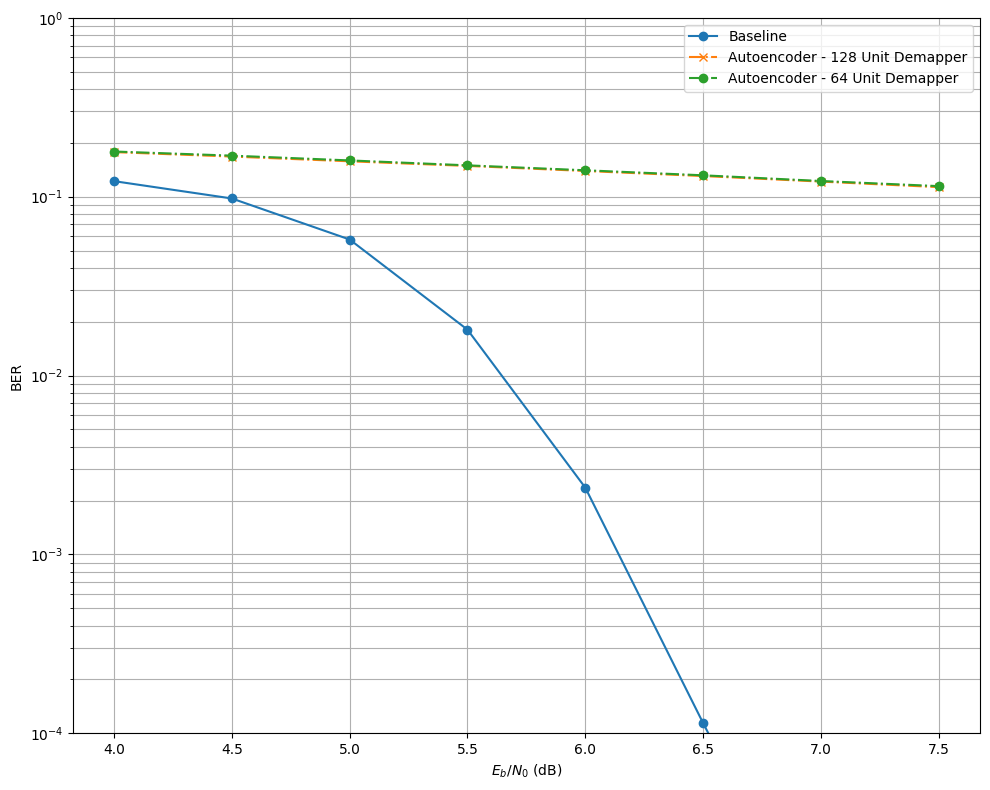

In [46]:
plt.figure(figsize=(10,8))
# Baseline - Perfect CSI
plt.semilogy(ebno_dbs, BER['baseline'], 'o-', c=f'C0', label=f'Baseline')
# Autoencoder - conventional training
plt.semilogy(ebno_dbs, BER['autoencoder-128units'] , 'x-.', c=f'C1', label=f'Autoencoder - 128 Unit Demapper')
# Autoencoder - RL-based training
plt.semilogy(ebno_dbs, BER['autoencoder-64units'], 'o-.', c=f'C2', label=f'Autoencoder - 64 Unit Demapper')

plt.xlabel(r"$E_b/N_0$ (dB)")
plt.ylabel("BER")
plt.grid(which="both")
plt.ylim((1e-4, 1))
plt.legend()
plt.tight_layout()

## Visualizing the Learned Constellations

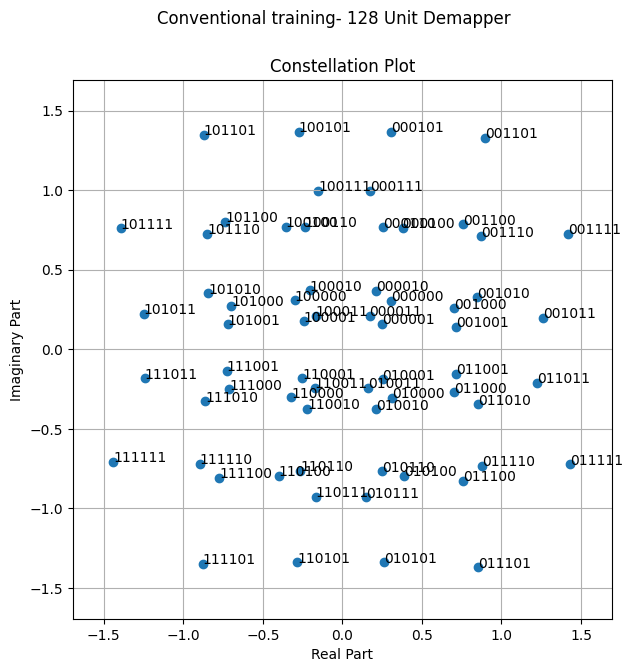

In [42]:
model_eval_128 = E2ESystemConventionalTraining(training=True, demapper=demapper_128)
load_weights(model_eval_128, model_weights_path_128_unit_Demapper_model)
fig = model_eval_128.constellation.show()
fig.suptitle('Conventional training- 128 Unit Demapper');

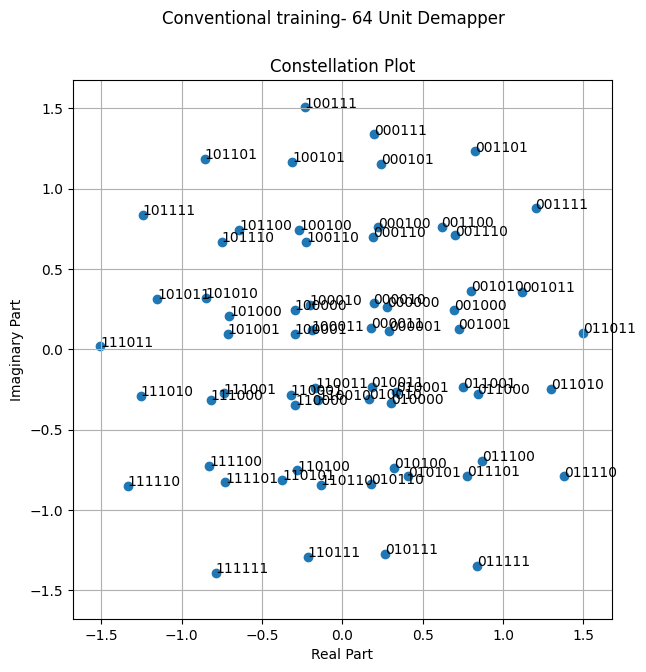

In [43]:
model_eval_64 = E2ESystemConventionalTraining(training=True, demapper=demapper_64)
load_weights(model_eval_64, model_weights_path_64_unit_Demapper_model)
fig = model_eval_64.constellation.show()
fig.suptitle('Conventional training- 64 Unit Demapper');

In [44]:
%rm awgn_autoencoder_weights_conventional_training awgn_autoencoder_weights_rl_training awgn_autoencoder_results

rm: cannot remove 'awgn_autoencoder_weights_conventional_training': No such file or directory
rm: cannot remove 'awgn_autoencoder_weights_rl_training': No such file or directory


## References

[1] T. O’Shea and J. Hoydis, "An Introduction to Deep Learning for the Physical Layer," in IEEE Transactions on Cognitive Communications and Networking, vol. 3, no. 4, pp. 563-575, Dec. 2017, doi: 10.1109/TCCN.2017.2758370.

[2] S. Cammerer, F. Ait Aoudia, S. Dörner, M. Stark, J. Hoydis and S. ten Brink, "Trainable Communication Systems: Concepts and Prototype," in IEEE Transactions on Communications, vol. 68, no. 9, pp. 5489-5503, Sept. 2020, doi: 10.1109/TCOMM.2020.3002915.

[3] F. Ait Aoudia and J. Hoydis, "Model-Free Training of End-to-End Communication Systems," in IEEE Journal on Selected Areas in Communications, vol. 37, no. 11, pp. 2503-2516, Nov. 2019, doi: 10.1109/JSAC.2019.2933891.